In [1]:
import torch
from models.vit import ViT
from models.ViT_CNN import ViT_CNN
from models.ViT_CNN_early_exit import ViT_CNN_early_exit
from functions import train_test
from functions import plotter
from functions import helpers
from functions import data_loader

In [2]:
torch.manual_seed(42)

CIFAR-100


In [3]:
train_loader, test_loader = data_loader.get_data_loader(
    80, 2, "datasets/cifar-100/cifar-100-python", download=True
)

Files already downloaded and verified
Files already downloaded and verified


CNN+ViT

Total parameters:671396


Test Accuracy: 54.01%


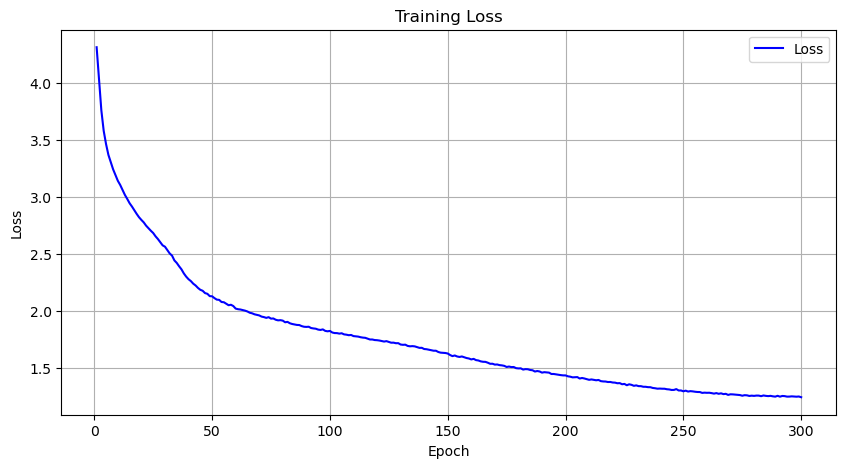

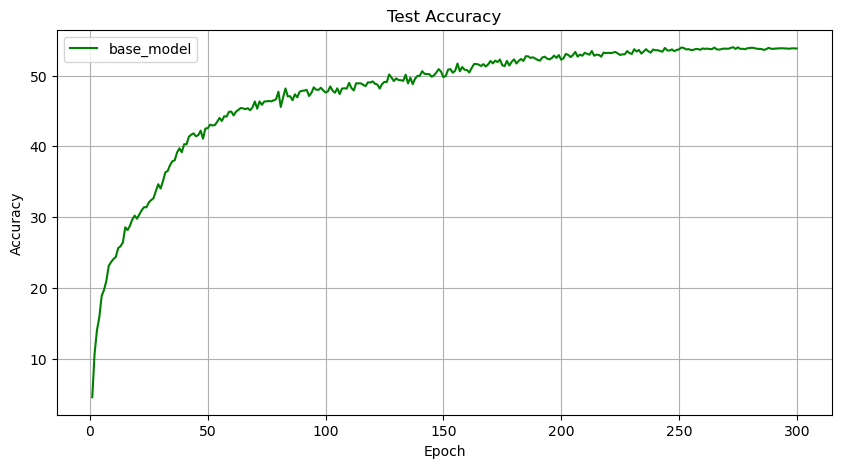

In [9]:
base_model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=4,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
).to(
    "cpu"
)  # cpu for feature visualisation
base_model_load_path = f"save_model/cifar-100/vit_base/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(base_model)}")
data_loader.load_checkpoint(base_model, base_model_load_path)
base_model_acc = train_test.test(base_model, test_loader, "cuda")
base_model_loss_list, base_model_accuracy_list = data_loader.load_lists_from_file(
    "save_model/cifar-100/vit_base/loss_and_accuracy"
)
plotter.plot_loss_accuracy(base_model_loss_list, base_model_accuracy_list, "base_model")

CNN pre ViT feautre extraction + CNN patch embedding

Total parameters:246404
Test Accuracy: 58.01%


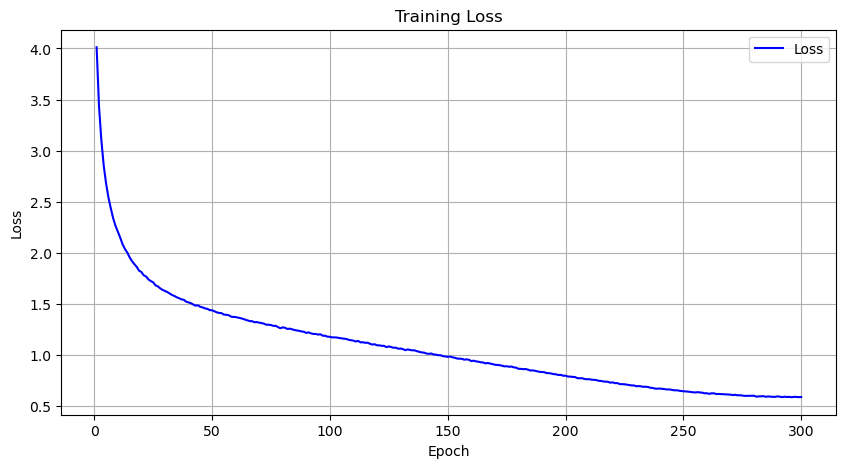

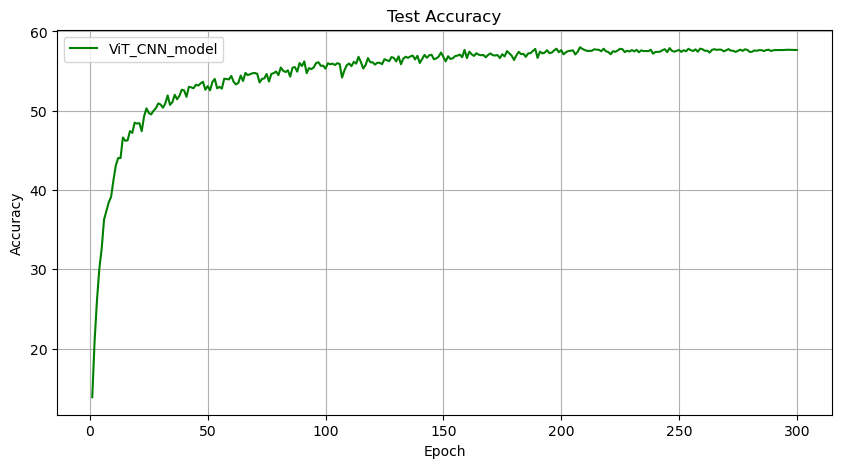

In [6]:
ViT_CNN_model = ViT_CNN(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=2,
    heads=4,
    mlp_dim=256,
    dropout=0.1,
).to(
    "cpu"
)  # cpu for feature visualisation
ViT_CNN_model_load_path = "save_model/cifar-100/ViT_CNN/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(ViT_CNN_model)}")
data_loader.load_checkpoint(ViT_CNN_model, ViT_CNN_model_load_path)
ViT_CNN_model_acc = train_test.test(ViT_CNN_model, test_loader, "cuda")
ViT_CNN_model_loss_list, ViT_CNN_model_accuracy_list = data_loader.load_lists_from_file(
    "save_model/cifar-100/ViT_CNN/loss_and_accuracy"
)
plotter.plot_loss_accuracy(
    ViT_CNN_model_loss_list, ViT_CNN_model_accuracy_list, "ViT_CNN_model"
)

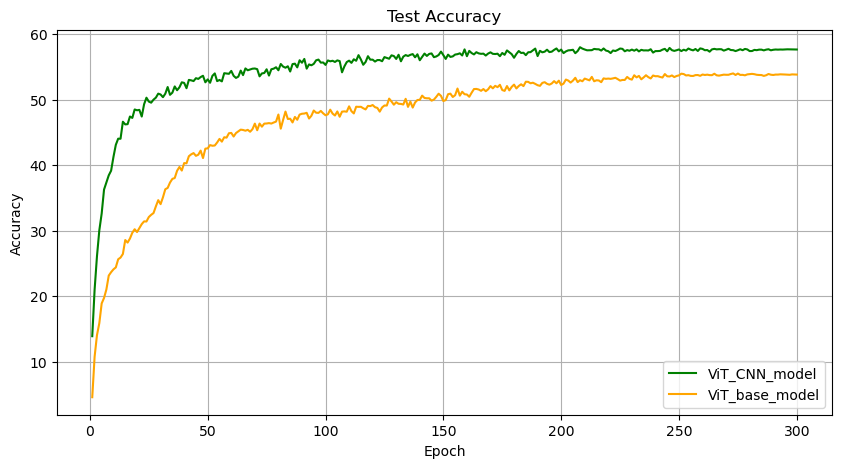

In [8]:
plotter.plot_accuracy_comparison(
    [ViT_CNN_model_accuracy_list, base_model_accuracy_list],
    ["ViT_CNN_model", "ViT_base_model"],
)

In [11]:
data_loader.create_comparison_table(
    [base_model, ViT_CNN_model],
    [base_model_acc, ViT_CNN_model_acc],
    ["ViT_base_model", "ViT_CNN_model"],
)

,model_name,num_params,accuracy,depth,num_heads,num_cnn_layers
1,ViT_CNN_model,246404,58.01,2,4,3
0,ViT_base_model,671396,54.01,4,8,0


Files already downloaded and verified
Files already downloaded and verified


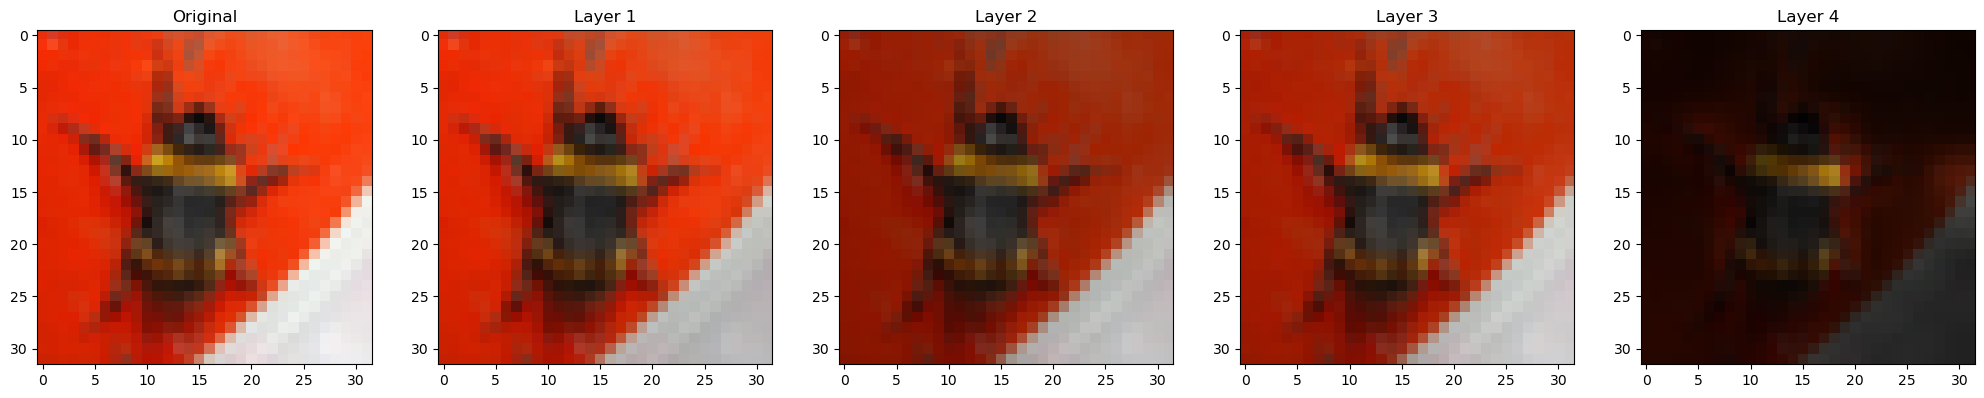

In [12]:
base_model.to("cpu")
x, img = data_loader.get_random_image("bee")
plotter.plot_feature_maps(base_model, x, img, device="cpu")

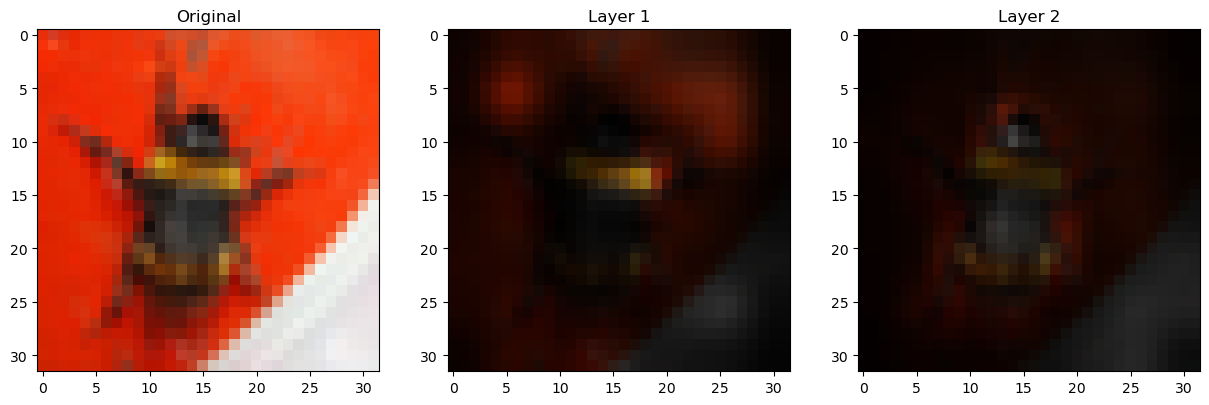

In [13]:
ViT_CNN_model.to("cpu")
plotter.plot_feature_maps(ViT_CNN_model, x, img, device="cpu")

Knowledge distillation

Student base model

Total parameters:408740


Test Accuracy: 51.56%


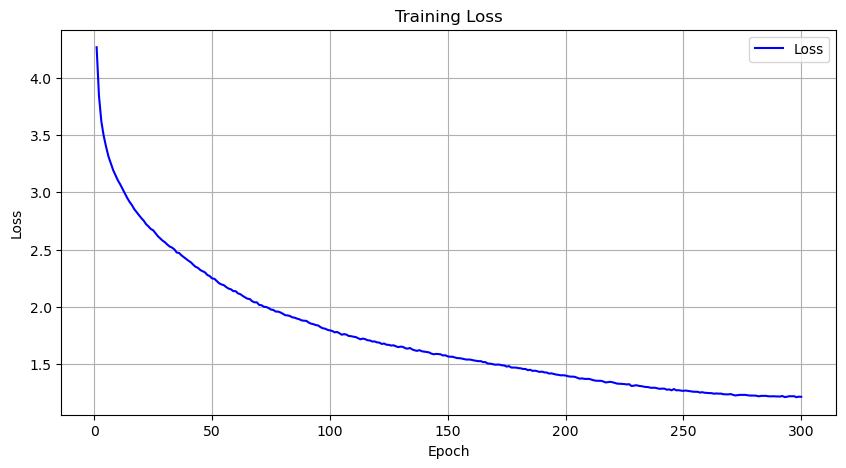

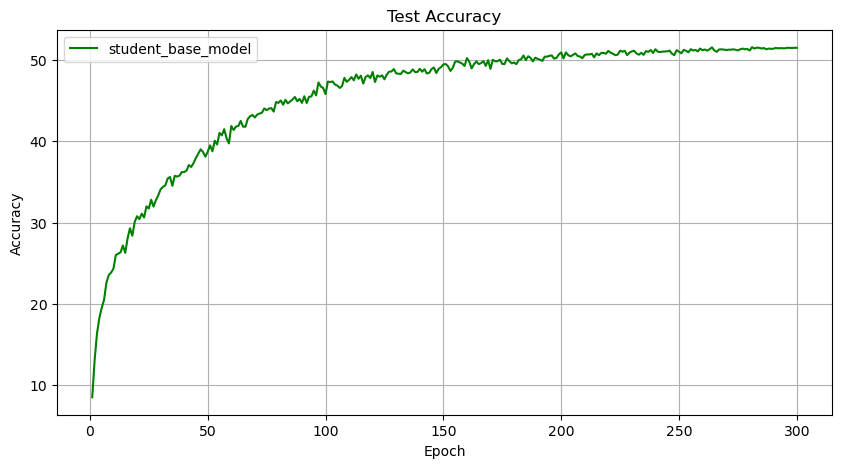

In [6]:
student_base_model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=3,
    heads=6,
    mlp_dim=256,
    dropout=0.1,
).to("cuda")
student_base_load_path = "save_model/cifar-100/vit_student_base/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(student_base_model)}")
data_loader.load_checkpoint(student_base_model, student_base_load_path)
student_base_model_acc = train_test.test(student_base_model, test_loader, "cuda")
(
    student_base_model_loss_list,
    student_base_model_accuracy_list,
) = data_loader.load_lists_from_file(
    "save_model/cifar-100/vit_student_base/loss_and_accuracy"
)
plotter.plot_loss_accuracy(
    student_base_model_loss_list, student_base_model_accuracy_list, "student_base_model"
)

Response based kd


Total parameters:408740


Test Accuracy: 54.87%


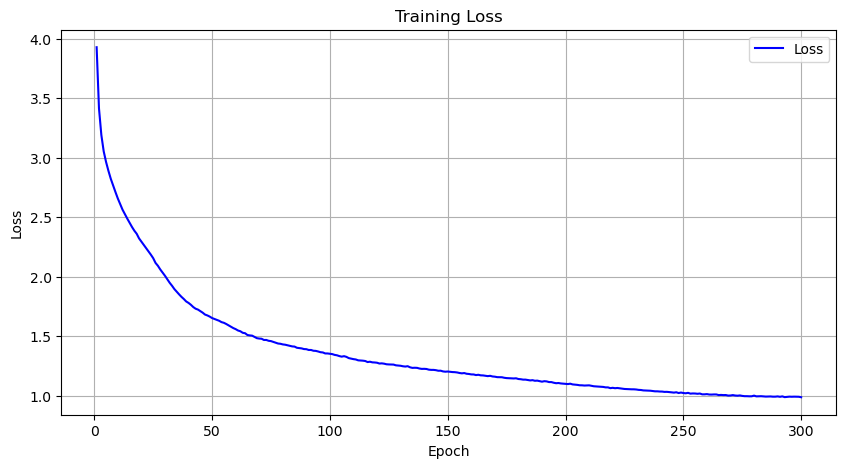

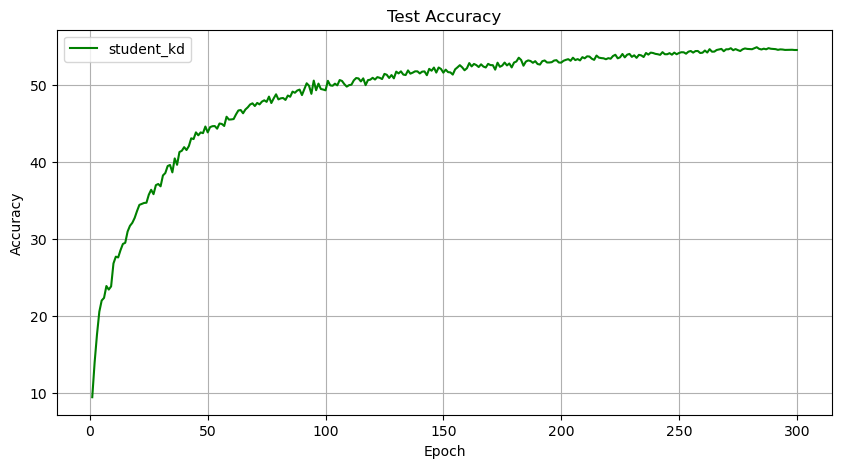

In [7]:
student_response_kd = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=3,
    heads=6,
    mlp_dim=256,
    dropout=0.1,
    feature_distill=False,
).to("cuda")
student_response_kd_path = "save_model/cifar-100/vit_student_kd/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(student_response_kd)}")
data_loader.load_checkpoint(student_response_kd, student_response_kd_path)
student_kd_acc = train_test.test(student_response_kd, test_loader, "cuda")
student_kd_loss_list, student_kd_accuracy_list = data_loader.load_lists_from_file(
    "save_model/cifar-100/vit_student_kd/loss_and_accuracy"
)
plotter.plot_loss_accuracy(student_kd_loss_list, student_kd_accuracy_list, "student_kd")

Feature based kd

Combined response+feature kd

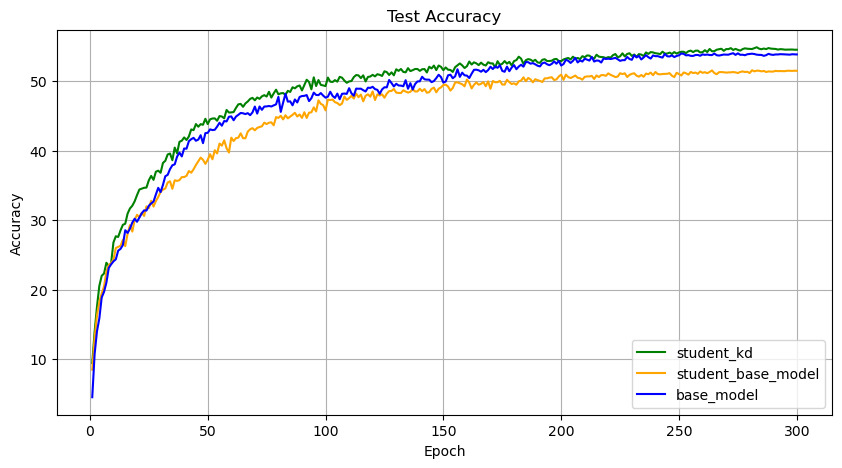

In [10]:
plotter.plot_accuracy_comparison(
    [student_kd_accuracy_list, student_base_model_accuracy_list,base_model_accuracy_list],
    ["student_kd", "student_base_model","base_model"],
)

In [9]:
data_loader.create_comparison_table(
    [
        base_model,
        student_base_model,
        student_response_kd,
    ],
    [base_model_acc,student_base_model_acc,student_kd_acc,],
    ["base_model","student_kd", "student_base_model"],
)

,model_name,num_params,accuracy,depth,num_heads,num_cnn_layers
2,student_base_model,408740,54.87,3,6,0
0,base_model,671396,54.01,4,8,0
1,student_kd,408740,51.56,3,6,0


In [ ]:
# Add inference time comparison and co2 eq

ViT_CNN early exit


In [11]:
ViT_CNN_early_exit_ = ViT_CNN_early_exit(
    image_size=32,
    dim=64,
    patch_size=4,
    num_classes=100,
    depth=4,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    early_exit=False,
).to("cuda")
ViT_early_exit_load_path = "save_model/cifar-100/ViT_CNN_early_exit3/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(ViT_CNN_early_exit_)}")
data_loader.load_checkpoint(ViT_CNN_early_exit_, ViT_early_exit_load_path)

TypeError: forward() got an unexpected keyword argument 'image_size'

In [15]:
ViT_early_exitacc = train_test.test(ViT_CNN_early_exit_, test_loader, "cuda")


Test Accuracy: 54.51%
Number of early exits: 0


In [6]:
ViT_CNN_early_exit = ViT_CNN_early_exit(
    image_size=32,
    dim=64,
    patch_size=4,
    num_classes=100,
    depth=4,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    early_exit=True,
).to("cuda")
ViT_early_exit_load_path = "save_model/cifar-100/ViT_CNN_early_exit3/best_model.pt"
print(f"Total parameters:{helpers.count_parameters(ViT_CNN_early_exit)}")
data_loader.load_checkpoint(ViT_CNN_early_exit, ViT_early_exit_load_path)

Total parameters:760136


In [ ]:
train_loader_1_example, test_loader_1_example = data_loader.get_data_loader(
    1, 2, "datasets/cifar-100/cifar-100-python", download=True
)


In [18]:

ViT_CNN_early_exit_acc, num_early_exits = train_test.test(
    ViT_CNN_early_exit, test_loader_1_example, "cuda"
)



Test Accuracy: 51.54%
Number of early exits: 948


In [16]:

ViT_CNN_early_exit_acc, num_early_exits = train_test.test(
    ViT_CNN_early_exit_, test_loader_1_example, "cuda"
)

Test Accuracy: 54.51%
Number of early exits: 0


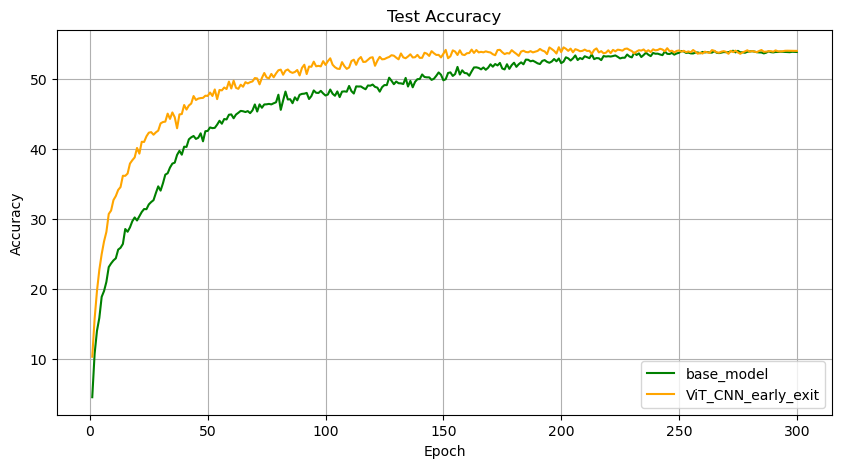

In [12]:
plotter.plot_accuracy_comparison(
    [base_model_accuracy_list, ViT_CNN_early_exit_model_accuracy_list],
    ["base_model", "ViT_CNN_early_exit"],
)

In [14]:
data_loader.create_comparison_table(
    [base_model, ViT_CNN_early_exit], [base_model_acc, ViT_CNN_early_exit_acc],
    ['base_model','ViT_CNN_early_exit']
)

,model_name,num_params,accuracy,depth,num_heads,num_cnn_layers
0,base_model,671396,54.01,4,8,0
1,ViT_CNN_early_exit,760136,51.54,4,8,1
